## HW04 DCGAN (PyTorch)

MNIST 데이터셋을 이용해 conditional generative adversarial networks (Conditional GAN) 기반 generative model을 구축한다.

1. 조건(condition)은 데이터의 label로 부여한다.
2. noise z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정한다.
3. 딥네트워크는 두 가지 구조로 설계해 본다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 fully-connected layer로 구성한다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 convolutional layer로 구현할 경우, 반드시 fully-connected layer 결과와 비교 분석하도록 한다.

다음을 확인하는 리포트를 Colab 노트북을 이용하여 작성한다.

1. 조건(condition)을 Conditional GAN의 생성 네트워크(G)와 판별 네트워크(D)에 어떻게 텐서 형태를 취해 입력으로 주어야 하는지 명시하고, 이에 대해 논의한다. 
2. 학습이 진행되며 네트워크가 고정된 noise 값으로부터 만들어내는 데이터의 모습이 어떻게 달라지는지 확인한다.
3. 매 epoch마다의 loss값을 저장하여 학습이 끝난 뒤 그래프로 나타낸다.
4. noise의 차원을 임의로 바꾸어 보고, 이때 결과가 어떻게 달라지는지 확인한다.

***

# DCGAN

* [I. J. Goodfellow et al., Generative Adversarial Nets (NIPS) 2014](https://arxiv.org/abs/1406.2661)
* [Radford et al., Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. ICLR 2016](https://arxiv.org/abs/1511.06434)
* [초짜 대학원생 입장에서 이해하는 Generative Adversarial Nets (유재준)](http://jaejunyoo.blogspot.com/2017/01/generative-adversarial-nets-1.html)
* [1시간만에 GAN(Generative Adversarial Network) 완전 정복하기, 네이버 D2 세미나](https://youtu.be/odpjk7_tGY0)
* [MIT, Introduction to Deep Learning, by A. Amini](http://introtodeeplearning.com/)
 + [Deep Generative Models (slides)](http://introtodeeplearning.com/materials/2019_6S191_L4.pdf)
* [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

아래는 추가적으로 볼만한 자료이다.
* [Myth of the Cave (플라톤의 동굴의 비유)](https://youtu.be/1RWOpQXTltA)
* [How I Fail S01E21: Ian Goodfellow (PhD’14, Computer Science)
](https://veronikach.com/how-i-fail/how-i-fail-ian-goodfellow-phd14-computer-science/)

## GAN 논문 소개
Generative Adversarial Networks (GANs)은 최근 딥러닝 방법론 중 가장 각광받고 생성 네트웍이다. Ian Goodfellow가 NIPS 2014 학술대회를 통해 발표한 이 기법은 기존의 생성 네트워크와는 달리 고품질 출력을 얻을 수 있는 것이 특징이다. 지난 4-5년 동안 GAN에 대한 수많은 연구가 이루어졌으며, 최근의 GAN 기법들은 그래픽스 렌더링을 한 것과 같은 매우 우수한 품질을 가지는 결과물도 얻어내고 있다. 

## GAN의 기본 아이디어

GAN의 기본 아이디어는 원 논문에서 다음과 같이 소개하고 있다.
> The generative model can be thought of as analogous to a team of counterfeiters, trying to produce face currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the ounterfeits are indistiguishable from the genuine articles. - Goodfellow et al. NIPS 2014.

GAN은 generator(생성자, 이하 G)와 discriminator(판별자, 이하 D)라는 두 네트웍이 경쟁적 관계 속에 학습한다. 

생성자 G와 판별자 D는 게임이론(game theory)에 기반한 2인 플레이 최적화 게임 방식으로 학습하는데, 각자 게임에서 좋은 평가를 받는 방식은 서로 다르다. 생성자 G는 판별자 D의 실수를 최대한 많이 유도하는 데이터를 만들어내면 좋은 평가를 받는 반면, 판별자 D는 생성자 G가 만들어낸 데이터(generated data)와 진실 데이터(ground-truth data)를 잘 구분하면 좋은 평가를 받는다. 

이런 종류의 문제를 **minmax two-play game**이라 한다. 

## GAN 네트웍 구조

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)


### Generator (생성자, G)
생성자 G의 목표는 데이터 $x$를 만들어내는 확률 모델 $p_g$를 학습해 내는 것이다. 

입력으로 다음과 같이 어떤 확률분포를 따르는 노이즈 $z$가 있다고 하면,
$$z \sim p_z(z)$$
생성자 G는 다음과 같이 노이즈 $z$를 입력으로 받아 생성 데이터를 만들어 내는 함수로 볼 수 있다.
$$ G(z; \theta_g) $$

생성자 G에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_g$를 생성자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.

### Discriminator (판별자, D)
판별자 D는 입력으로 데이터 $x$를 받고 이에 대한 판별을 한다. 
$$ D(x; \theta_d)$$

우리가 판별자에게 기대하는 바는 

* 입력 데이터 $x$가 진실 데이터로부터 나왔으면 판별자 D가 1을 리턴해 주고,
* 입력 데이터 $x$가 생성자 G가 만들어낸 것이라면 판별자 D는 0을 리턴해 주는 것이다.

판별자 D에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_d$를 판별자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.





### GAN 목적함수
I. Goodfellow는 GAN 논문에서 이와 같은 minmax two-play game을 두개의 적대적 네트웍으로 모델링하고 턴제 게임 방식의 훈련법을 제시하였다.

다음은 GAN 학습단계의 목적함수이다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$


판별자 D가 똑똑하게 훈련된다면 
* 진실 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] = 0$이 되어야 한다.
* 생성자 G가 만들어낸 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = 0$이 되어야 한다.

따라서, 판별자 D 입장에서 게임의 목표는 목적함수를 최대화 하는 것이다.


생성자 G가 똑똑하게 훈련되었다면
* 판별자 D를 속일만큼 양질의 데이터가 만들어졌기 때문에 $D(G(\mathbf{z})) = 1$이 되어야 하므로, 기대값 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = -\infty$이 된다.

따라서, 생성자 G 입장에서 게임의 목표는 목적함수를 최소화 하는 것이다.


### GAN v.s. VAE

학습 단계에서 VAE와 GAN은 다음 차이점이 있다.

* VAE에서 latent variable은 backprop에 참여하는 반면, visible unit (예: 영상)은 backprop에 참여하지 않는다.
* GAN에서 latent variable은 backprop에 참여하지 않는 반면, visible unit (예: 영상)은 backprop에 참여한다.

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.0+cu118
Torchvision:  0.15.1+cu118


## GPU 동작 확인

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [3]:
BATCH_SIZE = 256
learning_rate=0.0002
EPOCHS = 50

noise_dim = 100

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 84725279.28it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98886280.67it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27493873.40it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18441944.60it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

In [5]:
def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.


In [6]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [7]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

train dataset
>>> dataset length:  235
>>> batch_size:  256
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([256, 1, 28, 28])
>>> batch_images dtype torch.float32


![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Convolution
https://github.com/vdumoulin/conv_arithmetic

### Convolution
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif)


### Conv2DTranspose
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_transposed.gif)

## TODO (1)

아래의 네트워크를 __Conditional GAN__으로 수정한다.

1. 조건(condition)은 데이터의 label로 주어져야 하며, 
2. 이 조건이 어떤 형태의 텐서가 되어 어떻게 network G와 network D에 입력으로 주어져야 하는지 명시한다.
3. 모든 레이어는 fully connected layer로 구성한다. (Convolution layer로 구현할 경우 반드시 fully connected layer로 구현했을 경우와 비교 분석해볼 것.)

## Generator & Discriminator 네트워크 정의


### TODO 1

#### FC
- Generator에서 Conditional은 noise_dim의 rnadom한 noise를 생성한 이후 그 noise에 conditional을 추가해준다.
- Discriminator에서는 Conditional을 입력으로 들어온 이미지를 flatten을 이용하여 vectorize한 후 뒤에 붙여주는 식으로 처리했다.

#### CNN
- Generator에서는 FC레이어와 마찬가지로 noise_dim 크기의 random한 noise 생성 후 conditional을 추가해 줌

- Discriminator에서는 입력으로 들어온 batch_size x 1 x 28 x 28 크기의 이미지에 맞게 Conditional을  batch_size x 10 x 28 x 28 크기로 reshape해준 후 이미지와 합쳐서 batch_size x 11 x 28 x 28의 형태로 조건을 추가해 주었음.


In [8]:
num_classes = 10

In [9]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
## TODO
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1    = torch.nn.Linear(100 + num_classes, 512, bias=False)
        self.linear2    = torch.nn.Linear(512, 256, bias=False)
        self.linear3    = torch.nn.Linear(256, 128, bias=False)
        self.linear4    = torch.nn.Linear(128, 64, bias=False)
        self.linear5    = torch.nn.Linear(64, 1*28*28, bias=False)
  
        self.dropout    = torch.nn.Dropout(0.25)
        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
        z = self.dropout(self.lrelu(self.linear1(z)))
        z = self.dropout(self.lrelu(self.linear2(z)))
        z = self.dropout(self.lrelu(self.linear3(z)))
        z = self.dropout(self.lrelu(self.linear4(z)))
        z = self.tanh(self.linear5(z)).reshape(-1, 1, 28, 28)

        return z

    def forward(self, z, c):
        z = torch.cat((z, c), dim=1)
        #-- 조건 추가 noise_dim + conditional 
        z = self.generator(z)
        return z

G = Generator().to(device)

In [11]:
## TODO
class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear     = torch.nn.Linear(100 + num_classes, 7*7*512, bias=False) 
        self.bn        = torch.nn.BatchNorm1d(num_features=7*7*512)

        self.convt1     = torch.nn.ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn1        = torch.nn.BatchNorm2d(256)

        self.convt2     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn2        = torch.nn.BatchNorm2d(128)
        self.convt3     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
        self.bn3        = torch.nn.BatchNorm2d(64)
        self.convt4     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
      z = self.lrelu(self.bn(self.linear(z))).reshape(-1, 512, 7, 7)
      z = self.lrelu(self.bn1(self.convt1(z)))
      z = self.lrelu(self.bn2(self.convt2(z)))
      z = self.lrelu(self.bn3(self.convt3(z)))
      z = self.tanh(self.convt4(z)).reshape(-1, 1, 28, 28)

      return z

    def forward(self, z, c):
      z = torch.cat((z, c), dim=1)
      z = self.generator(z)

      return z

Conv_G = CondGenerator().to(device)

## Generator 구조 확인

- torchinfo 라이브러리를 사용

In [12]:
#-- FC Generator
from torchinfo import summary

summary(G, [(BATCH_SIZE, 100), (BATCH_SIZE, 10)])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 512]                56,320
├─LeakyReLU: 1-2                         [256, 512]                --
├─Dropout: 1-3                           [256, 512]                --
├─Linear: 1-4                            [256, 256]                131,072
├─LeakyReLU: 1-5                         [256, 256]                --
├─Dropout: 1-6                           [256, 256]                --
├─Linear: 1-7                            [256, 128]                32,768
├─LeakyReLU: 1-8                         [256, 128]                --
├─Dropout: 1-9                           [256, 128]                --
├─Linear: 1-10                           [256, 64]                 8,192
├─LeakyReLU: 1-11                        [256, 64]                 --
├─Dropout: 1-12                          [256, 64]                 --

In [13]:
#-- CNN Generator
from torchinfo import summary

summary(Conv_G, [(BATCH_SIZE, 100), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 25088]              2,759,680
├─BatchNorm1d: 1-2                       [256, 25088]              50,176
├─LeakyReLU: 1-3                         [256, 25088]              --
├─ConvTranspose2d: 1-4                   [256, 256, 7, 7]          3,276,800
├─BatchNorm2d: 1-5                       [256, 256, 7, 7]          512
├─LeakyReLU: 1-6                         [256, 256, 7, 7]          --
├─ConvTranspose2d: 1-7                   [256, 128, 7, 7]          819,200
├─BatchNorm2d: 1-8                       [256, 128, 7, 7]          256
├─LeakyReLU: 1-9                         [256, 128, 7, 7]          --
├─ConvTranspose2d: 1-10                  [256, 64, 14, 14]         131,072
├─BatchNorm2d: 1-11                      [256, 64, 14, 14]         128
├─LeakyReLU: 1-12                        [256, 64, 14,

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
      super().__init__()

      self.input      = torch.nn.Flatten()
      self.linear1    = torch.nn.Linear(28*28*1 + num_classes, 128, bias=False)
      # self.linear2    = torch.nn.Linear(512, 256, bias=False)
      # self.linear3    = torch.nn.Linear(256, 128, bias=False)
      self.linear2    = torch.nn.Linear(128, 64, bias=False)
      self.linear3    = torch.nn.Linear(64, 1, bias=False)

      self.lrelu      = torch.nn.LeakyReLU()
      self.sigmoid    = torch.nn.Sigmoid()
      self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
      z = self.dropout(self.lrelu(self.linear1(z)))
      z = self.dropout(self.lrelu(self.linear2(z)))
      z = self.sigmoid(self.linear3(z))

      return z

    def forward(self, z, c):
      z = self.input(z)
      z = torch.cat([z, c], dim=1)
      z = self.discriminator(z)

      return z

D = Discriminator().to(device)

In [36]:
## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1      = torch.nn.Conv2d(1+num_classes, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
      self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
      self.conv3      = torch.nn.Conv2d(128, 256, (4, 4), stride=(2, 2), padding=1, bias=False)

      self.flatten    = torch.nn.Flatten()
      self.linear     = torch.nn.Linear(7*7*256, 1, bias=False)

      self.lrelu      = torch.nn.LeakyReLU()
      self.sigmoid    = torch.nn.Sigmoid()
      self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
      z = self.dropout(self.lrelu(self.conv1(z)))
      z = self.dropout(self.lrelu(self.conv2(z)))
      z = self.dropout(self.lrelu(self.conv3(z)))
      z = self.flatten(self.dropout(self.lrelu(self.conv4(z))))
  
      z = self.sigmoid(self.linear(z))

      return z

    def forward(self, z):
      c = c.view(-1, 10, 1, 1)
      c = c.expand(-1, 10, -1, -1)
      z = torch.cat([z, c], dim=-3)
      z = self.discriminator(z)

      return z

Conv_D = Discriminator().to(device)

## Discriminator 구조 확인

- torchinfo 라이브러리를 사용

In [16]:
#-- FC Generator
summary(D, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, num_classes)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [256, 1]                  --
├─Flatten: 1-1                           [256, 784]                --
├─Linear: 1-2                            [256, 512]                406,528
├─LeakyReLU: 1-3                         [256, 512]                --
├─Dropout: 1-4                           [256, 512]                --
├─Linear: 1-5                            [256, 256]                131,072
├─LeakyReLU: 1-6                         [256, 256]                --
├─Dropout: 1-7                           [256, 256]                --
├─Linear: 1-8                            [256, 128]                32,768
├─LeakyReLU: 1-9                         [256, 128]                --
├─Dropout: 1-10                          [256, 128]                --
├─Linear: 1-11                           [256, 64]                 8,192
├─LeakyReLU: 1-12                        [256, 64]                 -

In [17]:
#-- CNN Generator
summary(Conv_D, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, num_classes)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [256, 1]                  --
├─Flatten: 1-1                           [256, 784]                --
├─Linear: 1-2                            [256, 512]                406,528
├─LeakyReLU: 1-3                         [256, 512]                --
├─Dropout: 1-4                           [256, 512]                --
├─Linear: 1-5                            [256, 256]                131,072
├─LeakyReLU: 1-6                         [256, 256]                --
├─Dropout: 1-7                           [256, 256]                --
├─Linear: 1-8                            [256, 128]                32,768
├─LeakyReLU: 1-9                         [256, 128]                --
├─Dropout: 1-10                          [256, 128]                --
├─Linear: 1-11                           [256, 64]                 8,192
├─LeakyReLU: 1-12                        [256, 64]                 -

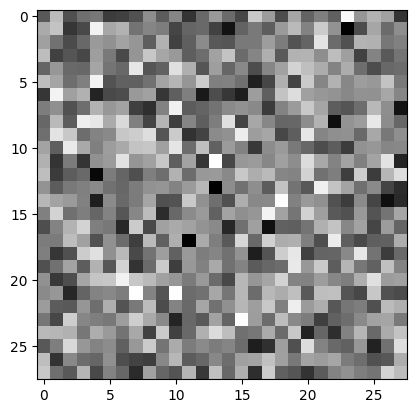

In [18]:
# FC_Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, 100), device=device)
#-- conditional 0생성
conditional = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) 
conditional = torch.tensor(conditional.astype(np.float32)).to(device)
G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = G(test_noise,conditional)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

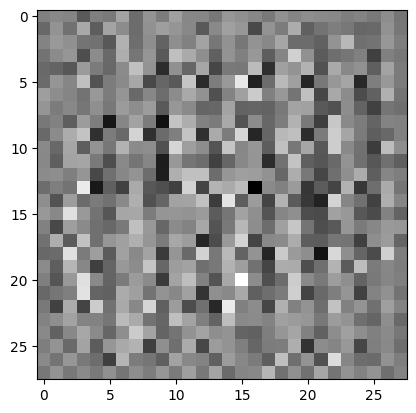

In [19]:
# CNN_Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, 100), device=device)
#-- conditional 0생성
conditional = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) 
conditional = torch.tensor(conditional.astype(np.float32)).to(device)
Conv_G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = Conv_G(test_noise,conditional)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

In [20]:
# FC_Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(fake_image_test, conditional)  

print(decision)

tensor([[0.5003]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [21]:
# CNN_Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
Conv_D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = Conv_D(fake_image_test, conditional)  

print(decision)

tensor([[0.4996]], device='cuda:0', grad_fn=<SigmoidBackward0>)


## GAN 목적함수
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$

### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

In [37]:
# FC_GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# FC_GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [38]:
# CNN_GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# CNN_GAN 트레이닝에 쓰일 optimizer 정의
Conv_G_optimizer = torch.optim.Adam(Conv_G.parameters(), lr=learning_rate)
Conv_D_optimizer = torch.optim.Adam(Conv_D.parameters(), lr=learning_rate)

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Training

마이크 타이슨의 명언: **누구나 그럴싸한 계획을 가지고 있다... 얻어맞기 전까지는...**
![대체 텍스트](https://cdn-images-1.medium.com/max/800/1*ocjDDF4WbSZl-WAFVUlqrg.jpeg)

## TODO (2)

1. 고정된 noise 값을 몇 개 생성한다.
2. Training 과정 중 일정 시점마다 (ex. epoch % 10 == 0) <br> network G가 (1)의 noise 값으로부터 만들어낸 가짜 데이터를 가시화 하여, 학습이 진행되며 어떻게 변화하는지 확인한다.


## TODO (3)

매 epoch마다 network G와 network D의 loss를 저장한 뒤 그래프로 가시화 한다. 각 network의 loss가 어떻게 변화하는지 논의한다.

<br><br>

(학습이 충분이 진행되지 않았다고 판단될 경우 epoch 횟수를 늘리거나 다른 의미있는 변화들을 추가해 본다.)

### TODO 2
5epoch 마다 고정된 노이즈 값을 지속적으로 넣어 학습하는 과정을 시각화

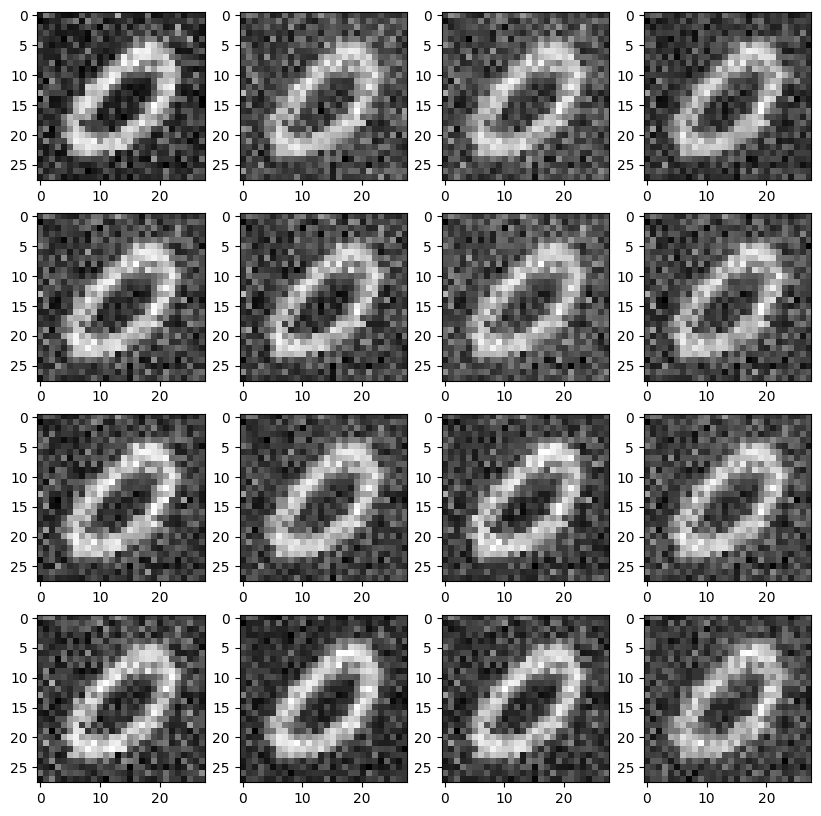

[0/50][0/235]	Loss_D: 0.0165	Loss_G: 8.5748	D(x): 0.9962	D(G(z)): 0.0036 / 0.0022
[0/50][50/235]	Loss_D: 0.0087	Loss_G: 12.6716	D(x): 0.9997	D(G(z)): 0.0039 / 0.0003
[0/50][100/235]	Loss_D: 0.0007	Loss_G: 11.8668	D(x): 0.9998	D(G(z)): 0.0005 / 0.0001
[0/50][150/235]	Loss_D: 0.0095	Loss_G: 12.6255	D(x): 1.0000	D(G(z)): 0.0060 / 0.0001
[0/50][200/235]	Loss_D: 0.0036	Loss_G: 10.4265	D(x): 0.9993	D(G(z)): 0.0022 / 0.0010
[1/50][0/235]	Loss_D: 0.0004	Loss_G: 15.4779	D(x): 0.9999	D(G(z)): 0.0003 / 0.0001
[1/50][50/235]	Loss_D: 0.0060	Loss_G: 12.7662	D(x): 0.9988	D(G(z)): 0.0030 / 0.0001
[1/50][100/235]	Loss_D: 0.0005	Loss_G: 10.2608	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[1/50][150/235]	Loss_D: 0.0013	Loss_G: 11.9569	D(x): 0.9990	D(G(z)): 0.0003 / 0.0013
[1/50][200/235]	Loss_D: 0.0005	Loss_G: 12.2238	D(x): 0.9999	D(G(z)): 0.0004 / 0.0001
[2/50][0/235]	Loss_D: 0.0041	Loss_G: 11.3091	D(x): 0.9997	D(G(z)): 0.0030 / 0.0006
[2/50][50/235]	Loss_D: 0.0013	Loss_G: 12.2323	D(x): 0.9993	D(G(z)): 0.0005

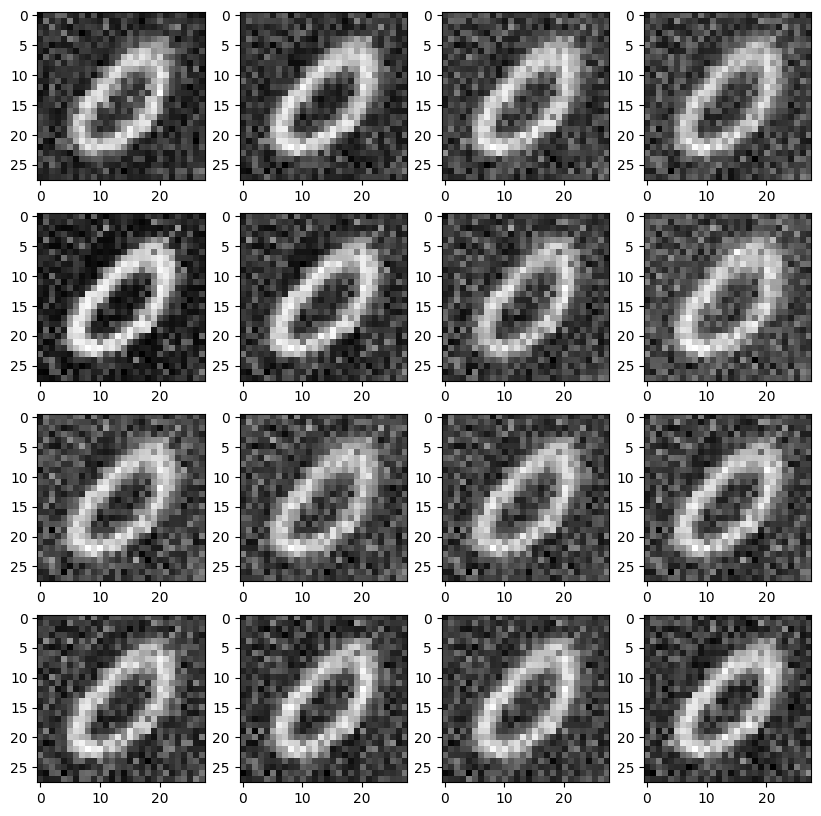

[10/50][0/235]	Loss_D: 0.0091	Loss_G: 14.0713	D(x): 0.9963	D(G(z)): 0.0002 / 0.0005
[10/50][50/235]	Loss_D: 0.0060	Loss_G: 10.3399	D(x): 0.9965	D(G(z)): 0.0012 / 0.0041
[10/50][100/235]	Loss_D: 0.0035	Loss_G: 13.6751	D(x): 0.9981	D(G(z)): 0.0009 / 0.0041
[10/50][150/235]	Loss_D: 0.0004	Loss_G: 20.0360	D(x): 0.9997	D(G(z)): 0.0002 / 0.0000
[10/50][200/235]	Loss_D: 0.0098	Loss_G: 9.7075	D(x): 1.0000	D(G(z)): 0.0070 / 0.0062
[11/50][0/235]	Loss_D: 0.0234	Loss_G: 10.4710	D(x): 0.9960	D(G(z)): 0.0008 / 0.0007
[11/50][50/235]	Loss_D: 0.0207	Loss_G: 12.0948	D(x): 0.9961	D(G(z)): 0.0014 / 0.0013
[11/50][100/235]	Loss_D: 0.0032	Loss_G: 13.1669	D(x): 0.9982	D(G(z)): 0.0009 / 0.0016
[11/50][150/235]	Loss_D: 0.0214	Loss_G: 8.3539	D(x): 0.9995	D(G(z)): 0.0174 / 0.0035
[11/50][200/235]	Loss_D: 0.0130	Loss_G: 9.7939	D(x): 0.9926	D(G(z)): 0.0043 / 0.0034
[12/50][0/235]	Loss_D: 0.0067	Loss_G: 11.5871	D(x): 0.9964	D(G(z)): 0.0024 / 0.0003
[12/50][50/235]	Loss_D: 0.0041	Loss_G: 9.7141	D(x): 0.9992	D(G(z)

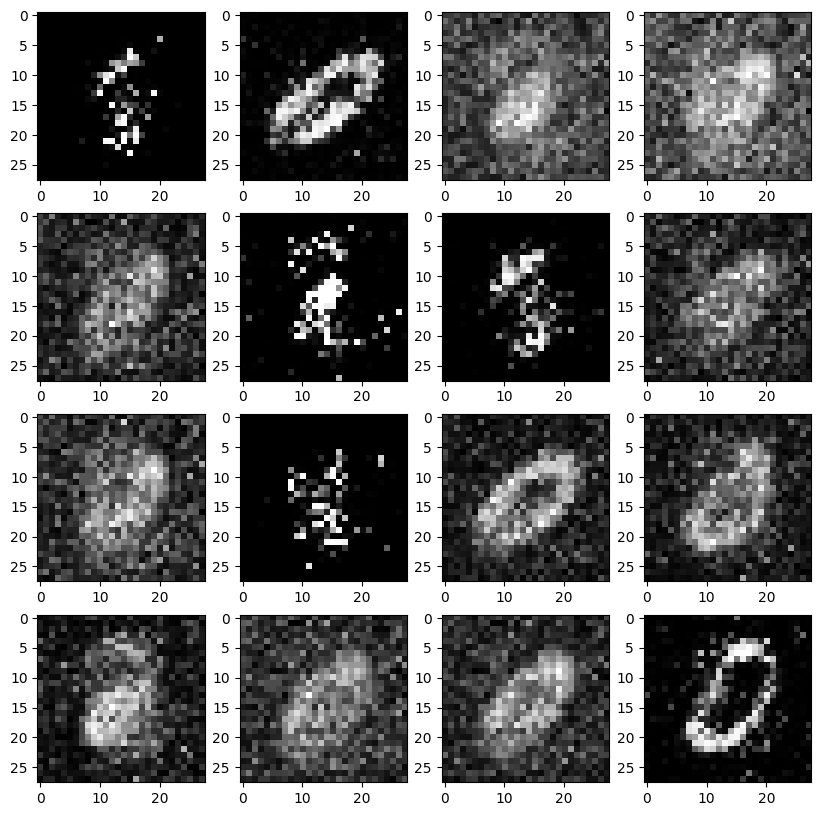

[20/50][0/235]	Loss_D: 0.0944	Loss_G: 8.6775	D(x): 0.9686	D(G(z)): 0.0132 / 0.0081
[20/50][50/235]	Loss_D: 0.0689	Loss_G: 7.0384	D(x): 0.9899	D(G(z)): 0.0404 / 0.0295
[20/50][100/235]	Loss_D: 0.0512	Loss_G: 7.7423	D(x): 0.9891	D(G(z)): 0.0197 / 0.0164
[20/50][150/235]	Loss_D: 0.1037	Loss_G: 4.3734	D(x): 0.9790	D(G(z)): 0.0443 / 0.0926
[20/50][200/235]	Loss_D: 0.0633	Loss_G: 7.1466	D(x): 0.9739	D(G(z)): 0.0156 / 0.0136
[21/50][0/235]	Loss_D: 0.0831	Loss_G: 8.1761	D(x): 0.9782	D(G(z)): 0.0083 / 0.0050
[21/50][50/235]	Loss_D: 0.0853	Loss_G: 8.5393	D(x): 0.9643	D(G(z)): 0.0106 / 0.0071
[21/50][100/235]	Loss_D: 0.0636	Loss_G: 8.9163	D(x): 0.9685	D(G(z)): 0.0045 / 0.0044
[21/50][150/235]	Loss_D: 0.1145	Loss_G: 5.0452	D(x): 0.9928	D(G(z)): 0.0606 / 0.0476
[21/50][200/235]	Loss_D: 0.0658	Loss_G: 7.1489	D(x): 0.9886	D(G(z)): 0.0345 / 0.0170
[22/50][0/235]	Loss_D: 0.0739	Loss_G: 6.2249	D(x): 0.9847	D(G(z)): 0.0291 / 0.0294
[22/50][50/235]	Loss_D: 0.0674	Loss_G: 7.5949	D(x): 0.9868	D(G(z)): 0.018

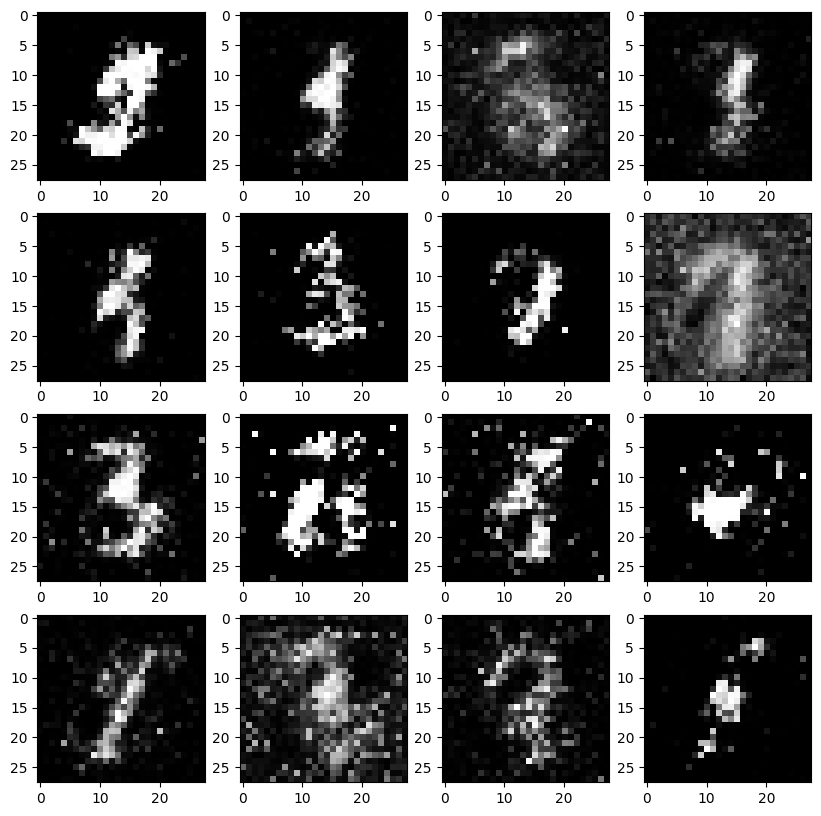

[30/50][0/235]	Loss_D: 0.2144	Loss_G: 5.0600	D(x): 0.9113	D(G(z)): 0.0413 / 0.0655
[30/50][50/235]	Loss_D: 0.1466	Loss_G: 6.0150	D(x): 0.9608	D(G(z)): 0.0654 / 0.0334
[30/50][100/235]	Loss_D: 0.1899	Loss_G: 6.5132	D(x): 0.9347	D(G(z)): 0.0540 / 0.0291
[30/50][150/235]	Loss_D: 0.2153	Loss_G: 4.8356	D(x): 0.9286	D(G(z)): 0.0494 / 0.0641
[30/50][200/235]	Loss_D: 0.2439	Loss_G: 5.5040	D(x): 0.9237	D(G(z)): 0.0480 / 0.0436
[31/50][0/235]	Loss_D: 0.3995	Loss_G: 6.5710	D(x): 0.8792	D(G(z)): 0.0247 / 0.0270
[31/50][50/235]	Loss_D: 0.1118	Loss_G: 6.4092	D(x): 0.9489	D(G(z)): 0.0304 / 0.0273
[31/50][100/235]	Loss_D: 0.2640	Loss_G: 4.7122	D(x): 0.9127	D(G(z)): 0.0360 / 0.0678
[31/50][150/235]	Loss_D: 0.1833	Loss_G: 5.7931	D(x): 0.9303	D(G(z)): 0.0342 / 0.0453
[31/50][200/235]	Loss_D: 0.1407	Loss_G: 5.3514	D(x): 0.9587	D(G(z)): 0.0585 / 0.0396
[32/50][0/235]	Loss_D: 0.2481	Loss_G: 4.7261	D(x): 0.9081	D(G(z)): 0.0493 / 0.0650
[32/50][50/235]	Loss_D: 0.2424	Loss_G: 4.8634	D(x): 0.9421	D(G(z)): 0.076

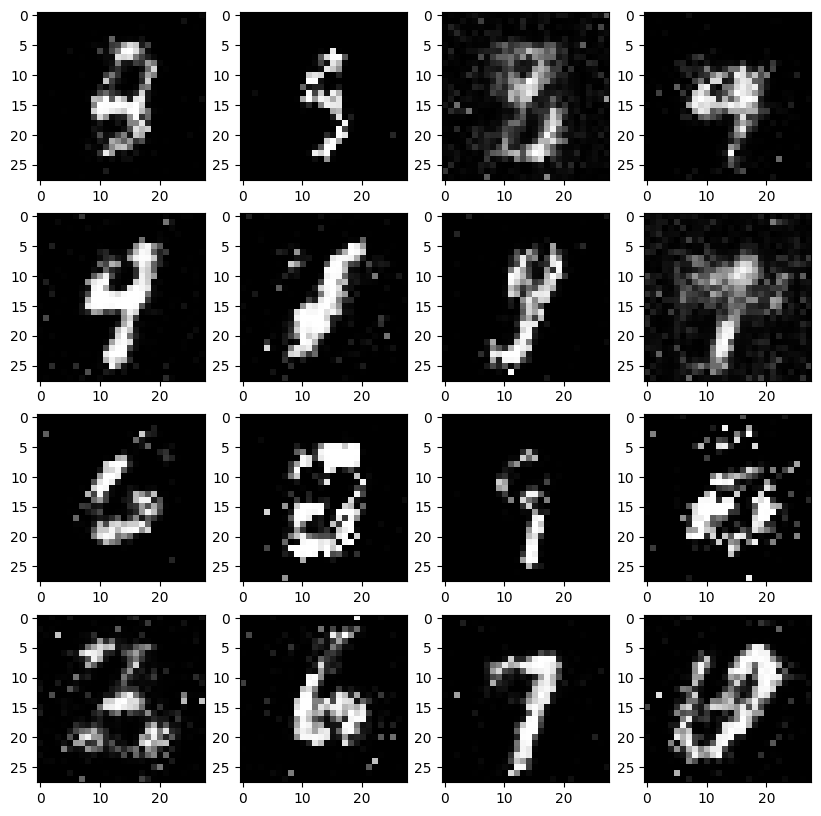

[40/50][0/235]	Loss_D: 0.3399	Loss_G: 3.6060	D(x): 0.9008	D(G(z)): 0.1125 / 0.1260
[40/50][50/235]	Loss_D: 0.2851	Loss_G: 3.6487	D(x): 0.9046	D(G(z)): 0.0918 / 0.1068
[40/50][100/235]	Loss_D: 0.4862	Loss_G: 4.3332	D(x): 0.8658	D(G(z)): 0.1085 / 0.0886
[40/50][150/235]	Loss_D: 0.3811	Loss_G: 4.3097	D(x): 0.8626	D(G(z)): 0.0740 / 0.0718
[40/50][200/235]	Loss_D: 0.3670	Loss_G: 3.3391	D(x): 0.9017	D(G(z)): 0.1124 / 0.1238
[41/50][0/235]	Loss_D: 0.3218	Loss_G: 3.8025	D(x): 0.9251	D(G(z)): 0.1230 / 0.1024
[41/50][50/235]	Loss_D: 0.4223	Loss_G: 3.9155	D(x): 0.8746	D(G(z)): 0.1006 / 0.1156
[41/50][100/235]	Loss_D: 0.3838	Loss_G: 3.7759	D(x): 0.9283	D(G(z)): 0.1444 / 0.1160
[41/50][150/235]	Loss_D: 0.3579	Loss_G: 3.4631	D(x): 0.9139	D(G(z)): 0.1281 / 0.1252
[41/50][200/235]	Loss_D: 0.4867	Loss_G: 3.1601	D(x): 0.8432	D(G(z)): 0.1147 / 0.1345
[42/50][0/235]	Loss_D: 0.3859	Loss_G: 3.8651	D(x): 0.8709	D(G(z)): 0.0805 / 0.0994
[42/50][50/235]	Loss_D: 0.3566	Loss_G: 3.6134	D(x): 0.9196	D(G(z)): 0.135

In [30]:
#-- FC Train

#-- 고정된 값 생성
sample_noises = torch.randn((16, 100), device=device)
sample_conditional = torch.randint(0,10,(16,), device=device)
sample_conditional = F.one_hot(sample_conditional, num_classes=10).to(device)


G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  if epoch % 10 == 0: #-- 10epoch마다 고정된 노이즈 값 시각화
    smaple_images = G(sample_noises, sample_conditional)
    plt.figure(figsize=(10,10))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.imshow(smaple_images[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
    plt.show()


  for i, (images, train_labels) in enumerate(train_loader):

    train_labels_one_hot = F.one_hot(train_labels, num_classes=10).to(device)
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    y_pred_real = D(images_real, train_labels_one_hot).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = G(noises, train_labels_one_hot)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach(), train_labels_one_hot).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake, train_labels_one_hot).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
            
  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')

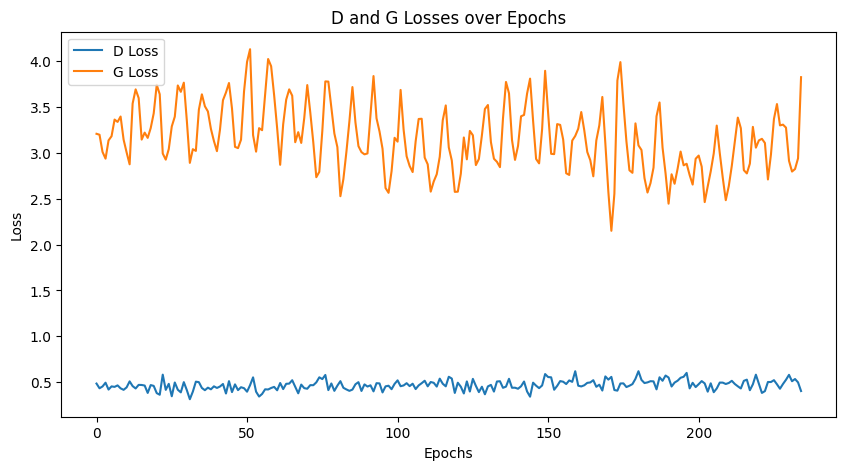

In [31]:
#-- FC LOSS 시각화

# 로스 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label='D Loss')
plt.plot(G_losses, label='G Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('D and G Losses over Epochs')
plt.show()

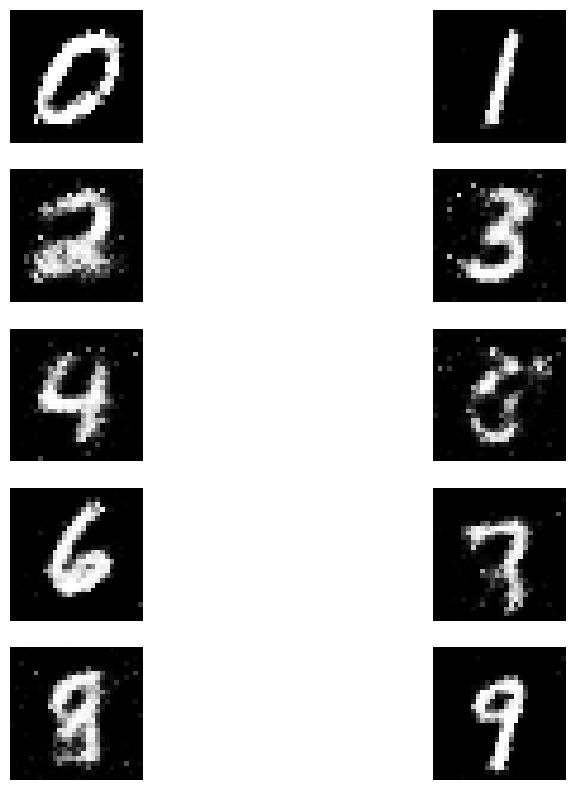

In [39]:
# FC Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

G.eval()
noises = torch.randn(10, 100, device=device)
label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label_encoded = F.one_hot(label, num_classes=num_classes).to(device)
generated_image = G(noises,label_encoded).cpu().detach().numpy().squeeze()


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

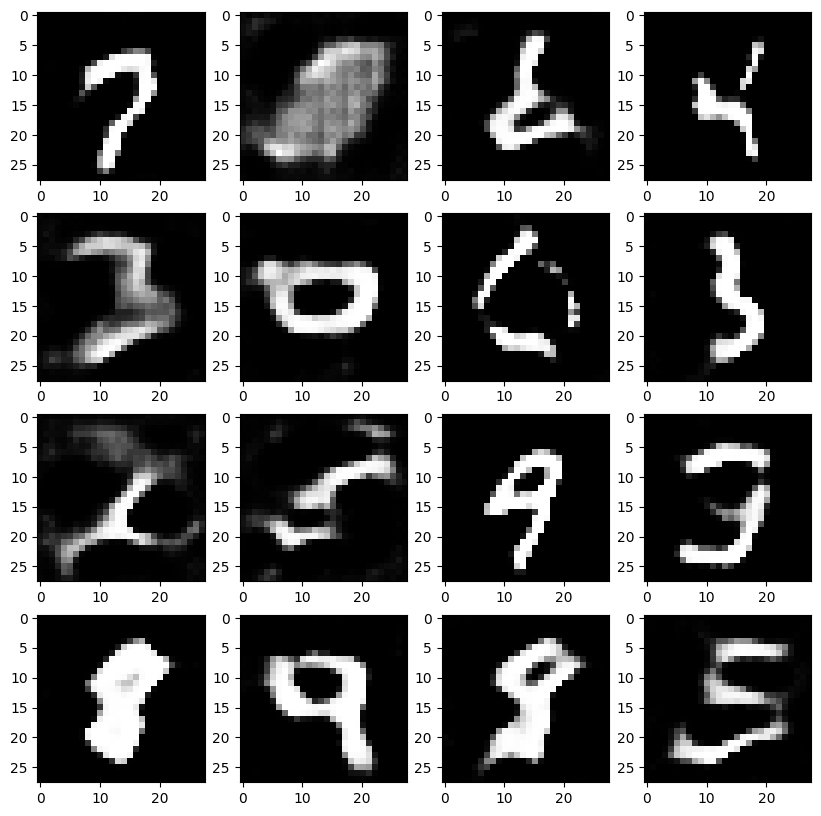

[0/50][0/235]	Loss_Conv_D: 1.3761	Loss_Conv_G: 0.6965	D(x): 0.5111	Conv_D(Conv_G(z)): 0.5025 / 0.5004
[0/50][50/235]	Loss_Conv_D: 1.3617	Loss_Conv_G: 0.7213	D(x): 0.5062	Conv_D(Conv_G(z)): 0.4898 / 0.4877
[0/50][100/235]	Loss_Conv_D: 1.3477	Loss_Conv_G: 0.7729	D(x): 0.4993	Conv_D(Conv_G(z)): 0.4716 / 0.4661
[0/50][150/235]	Loss_Conv_D: 1.3501	Loss_Conv_G: 0.7289	D(x): 0.5173	Conv_D(Conv_G(z)): 0.4886 / 0.4867
[0/50][200/235]	Loss_Conv_D: 1.3812	Loss_Conv_G: 0.7681	D(x): 0.5191	Conv_D(Conv_G(z)): 0.4825 / 0.4803
[1/50][0/235]	Loss_Conv_D: 1.3762	Loss_Conv_G: 0.7353	D(x): 0.4956	Conv_D(Conv_G(z)): 0.4858 / 0.4826
[1/50][50/235]	Loss_Conv_D: 1.3741	Loss_Conv_G: 0.7219	D(x): 0.5042	Conv_D(Conv_G(z)): 0.4924 / 0.4884
[1/50][100/235]	Loss_Conv_D: 1.3348	Loss_Conv_G: 0.6842	D(x): 0.5472	Conv_D(Conv_G(z)): 0.5074 / 0.5103
[1/50][150/235]	Loss_Conv_D: 1.3818	Loss_Conv_G: 0.7129	D(x): 0.5042	Conv_D(Conv_G(z)): 0.4947 / 0.4928
[1/50][200/235]	Loss_Conv_D: 1.3742	Loss_Conv_G: 0.7520	D(x): 0.4905	C

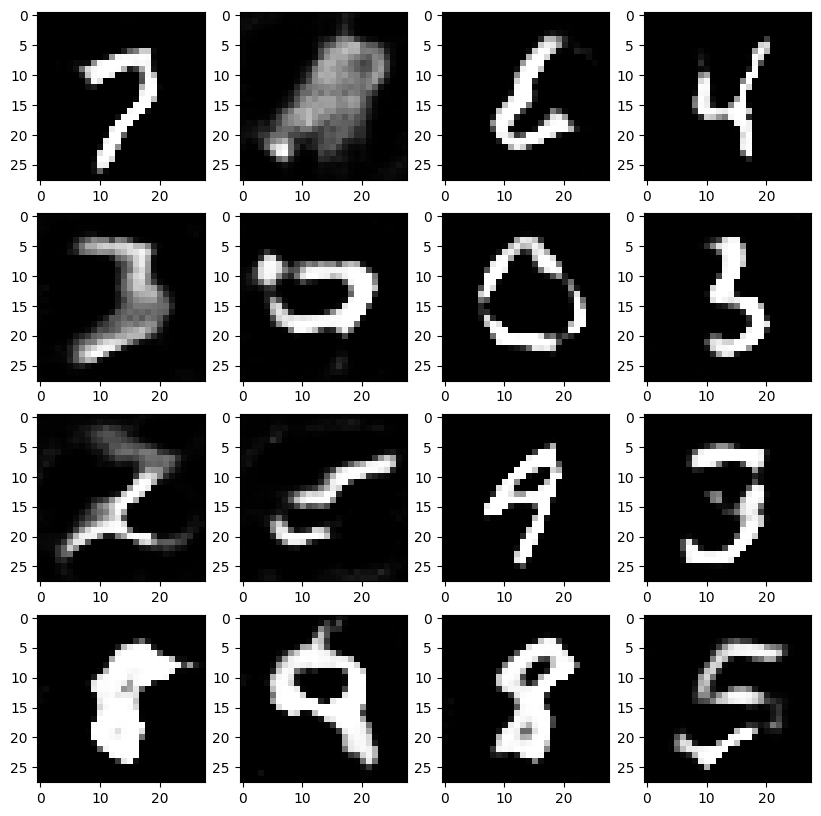

[10/50][0/235]	Loss_Conv_D: 1.3444	Loss_Conv_G: 0.6776	D(x): 0.5313	Conv_D(Conv_G(z)): 0.5055 / 0.5092
[10/50][50/235]	Loss_Conv_D: 1.3760	Loss_Conv_G: 0.6768	D(x): 0.5165	Conv_D(Conv_G(z)): 0.5072 / 0.5095
[10/50][100/235]	Loss_Conv_D: 1.3958	Loss_Conv_G: 0.7351	D(x): 0.5109	Conv_D(Conv_G(z)): 0.4834 / 0.4869
[10/50][150/235]	Loss_Conv_D: 1.2697	Loss_Conv_G: 0.8687	D(x): 0.5727	Conv_D(Conv_G(z)): 0.4726 / 0.4379
[10/50][200/235]	Loss_Conv_D: 1.3758	Loss_Conv_G: 0.6980	D(x): 0.5026	Conv_D(Conv_G(z)): 0.4963 / 0.4980
[11/50][0/235]	Loss_Conv_D: 1.3373	Loss_Conv_G: 0.6663	D(x): 0.5630	Conv_D(Conv_G(z)): 0.5250 / 0.5171
[11/50][50/235]	Loss_Conv_D: 1.3804	Loss_Conv_G: 0.6840	D(x): 0.5128	Conv_D(Conv_G(z)): 0.5073 / 0.5055
[11/50][100/235]	Loss_Conv_D: 1.3605	Loss_Conv_G: 0.8515	D(x): 0.4857	Conv_D(Conv_G(z)): 0.4362 / 0.4415
[11/50][150/235]	Loss_Conv_D: 1.3462	Loss_Conv_G: 0.6869	D(x): 0.5337	Conv_D(Conv_G(z)): 0.5049 / 0.5065
[11/50][200/235]	Loss_Conv_D: 1.3919	Loss_Conv_G: 0.7085	D(x)

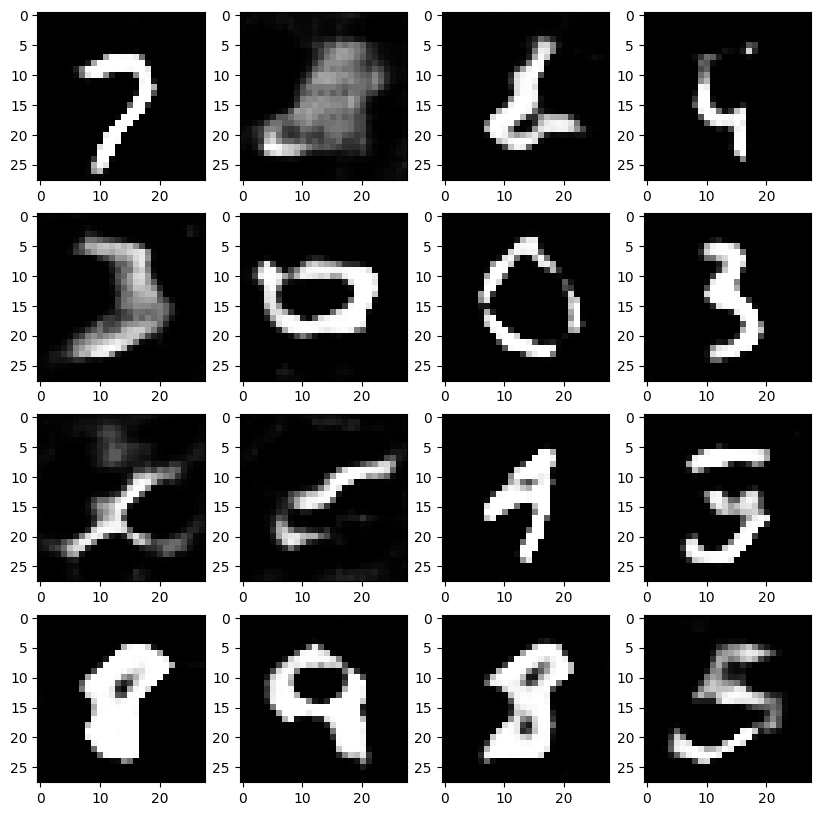

[20/50][0/235]	Loss_Conv_D: 1.3656	Loss_Conv_G: 0.7236	D(x): 0.5122	Conv_D(Conv_G(z)): 0.4890 / 0.4920
[20/50][50/235]	Loss_Conv_D: 1.3360	Loss_Conv_G: 0.6848	D(x): 0.5381	Conv_D(Conv_G(z)): 0.5041 / 0.5064
[20/50][100/235]	Loss_Conv_D: 1.4091	Loss_Conv_G: 0.7367	D(x): 0.4699	Conv_D(Conv_G(z)): 0.4781 / 0.4797
[20/50][150/235]	Loss_Conv_D: 1.2748	Loss_Conv_G: 0.6831	D(x): 0.5778	Conv_D(Conv_G(z)): 0.5037 / 0.5111
[20/50][200/235]	Loss_Conv_D: 1.3239	Loss_Conv_G: 0.6712	D(x): 0.5527	Conv_D(Conv_G(z)): 0.5107 / 0.5141
[21/50][0/235]	Loss_Conv_D: 1.4105	Loss_Conv_G: 0.7533	D(x): 0.4682	Conv_D(Conv_G(z)): 0.4748 / 0.4720
[21/50][50/235]	Loss_Conv_D: 1.3029	Loss_Conv_G: 0.6603	D(x): 0.6024	Conv_D(Conv_G(z)): 0.5294 / 0.5223
[21/50][100/235]	Loss_Conv_D: 1.3540	Loss_Conv_G: 0.7289	D(x): 0.5072	Conv_D(Conv_G(z)): 0.4852 / 0.4846
[21/50][150/235]	Loss_Conv_D: 1.3748	Loss_Conv_G: 0.7288	D(x): 0.4894	Conv_D(Conv_G(z)): 0.4798 / 0.4844
[21/50][200/235]	Loss_Conv_D: 1.3855	Loss_Conv_G: 0.7457	D(x)

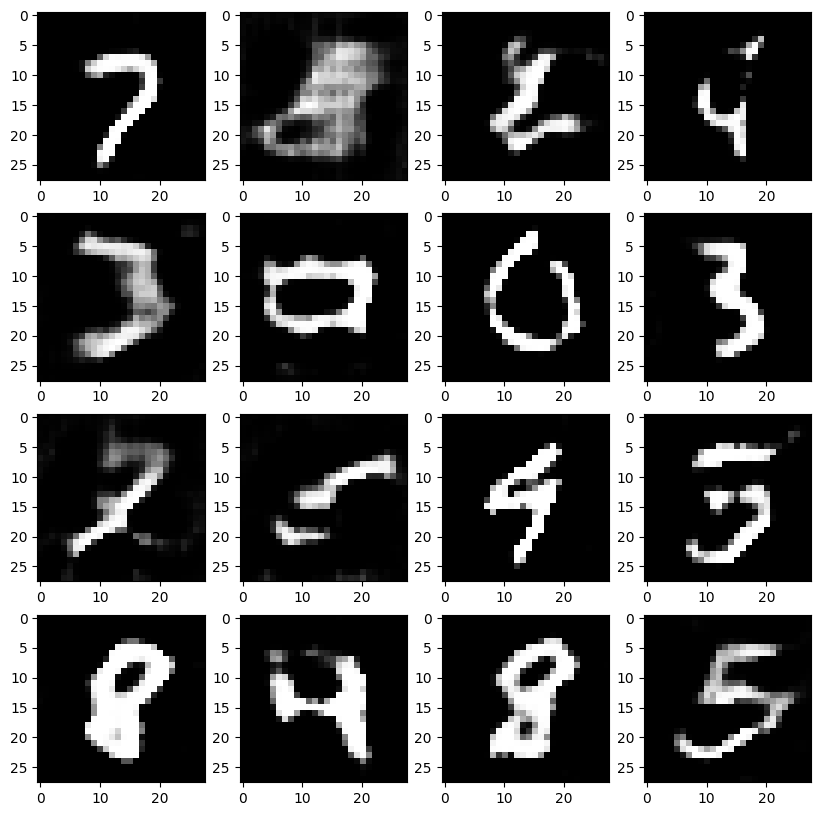

[30/50][0/235]	Loss_Conv_D: 1.3674	Loss_Conv_G: 0.6814	D(x): 0.5211	Conv_D(Conv_G(z)): 0.5024 / 0.5099
[30/50][50/235]	Loss_Conv_D: 1.3868	Loss_Conv_G: 0.7285	D(x): 0.4874	Conv_D(Conv_G(z)): 0.4817 / 0.4849
[30/50][100/235]	Loss_Conv_D: 1.4103	Loss_Conv_G: 0.7524	D(x): 0.4676	Conv_D(Conv_G(z)): 0.4734 / 0.4729
[30/50][150/235]	Loss_Conv_D: 1.3358	Loss_Conv_G: 0.8246	D(x): 0.5108	Conv_D(Conv_G(z)): 0.4579 / 0.4509
[30/50][200/235]	Loss_Conv_D: 1.3461	Loss_Conv_G: 0.6661	D(x): 0.5463	Conv_D(Conv_G(z)): 0.5189 / 0.5157
[31/50][0/235]	Loss_Conv_D: 1.3749	Loss_Conv_G: 0.6930	D(x): 0.5271	Conv_D(Conv_G(z)): 0.5075 / 0.5053
[31/50][50/235]	Loss_Conv_D: 1.3629	Loss_Conv_G: 0.6856	D(x): 0.5130	Conv_D(Conv_G(z)): 0.4958 / 0.5064
[31/50][100/235]	Loss_Conv_D: 1.3647	Loss_Conv_G: 0.7321	D(x): 0.5038	Conv_D(Conv_G(z)): 0.4847 / 0.4857
[31/50][150/235]	Loss_Conv_D: 1.3524	Loss_Conv_G: 0.7415	D(x): 0.5007	Conv_D(Conv_G(z)): 0.4790 / 0.4793
[31/50][200/235]	Loss_Conv_D: 1.3725	Loss_Conv_G: 0.6877	D(x)

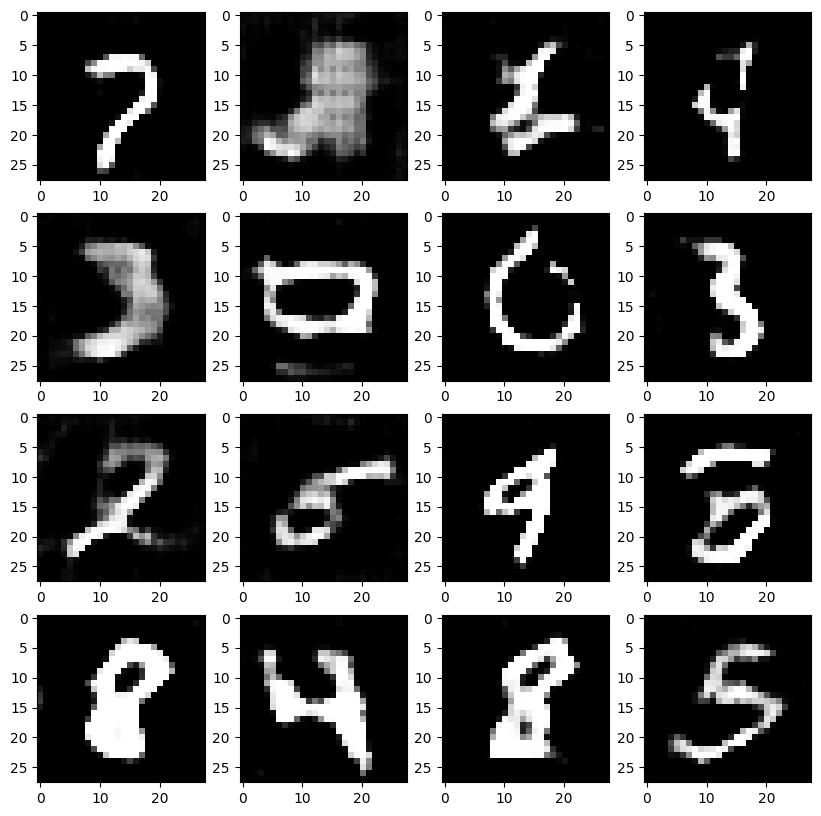

[40/50][0/235]	Loss_Conv_D: 1.3525	Loss_Conv_G: 0.6535	D(x): 0.5368	Conv_D(Conv_G(z)): 0.5151 / 0.5213
[40/50][50/235]	Loss_Conv_D: 1.3768	Loss_Conv_G: 0.7174	D(x): 0.5196	Conv_D(Conv_G(z)): 0.4966 / 0.4936
[40/50][100/235]	Loss_Conv_D: 1.3679	Loss_Conv_G: 0.7558	D(x): 0.4833	Conv_D(Conv_G(z)): 0.4708 / 0.4710
[40/50][150/235]	Loss_Conv_D: 1.3995	Loss_Conv_G: 0.6894	D(x): 0.4992	Conv_D(Conv_G(z)): 0.4973 / 0.5057
[40/50][200/235]	Loss_Conv_D: 1.3595	Loss_Conv_G: 0.8048	D(x): 0.4963	Conv_D(Conv_G(z)): 0.4679 / 0.4547
[41/50][0/235]	Loss_Conv_D: 1.3812	Loss_Conv_G: 0.6811	D(x): 0.5110	Conv_D(Conv_G(z)): 0.5065 / 0.5067
[41/50][50/235]	Loss_Conv_D: 1.4022	Loss_Conv_G: 0.7351	D(x): 0.5011	Conv_D(Conv_G(z)): 0.4958 / 0.4843
[41/50][100/235]	Loss_Conv_D: 1.3623	Loss_Conv_G: 0.7136	D(x): 0.5254	Conv_D(Conv_G(z)): 0.5018 / 0.4948
[41/50][150/235]	Loss_Conv_D: 1.3957	Loss_Conv_G: 0.7210	D(x): 0.4857	Conv_D(Conv_G(z)): 0.4843 / 0.4891
[41/50][200/235]	Loss_Conv_D: 1.3238	Loss_Conv_G: 0.7901	D(x)

In [44]:
#-- CNN Train

#-- 고정된 값 생성
sample_noises = torch.randn((16, 100), device=device)
sample_conditional = torch.randint(0,10,(16,), device=device)
sample_conditional = F.one_hot(sample_conditional, num_classes=10).to(device)

Conv_G.train()
Conv_D.train()

train_hist = {}
train_hist['Conv_D_losses'] = []
train_hist['Conv_G_losses'] = []

for epoch in range(EPOCHS):
  Conv_D_losses = []
  Conv_G_losses = []

  if epoch % 10 == 0: #-- 10epoch마다 고정된 노이즈 값 시각화
    smaple_images = Conv_G(sample_noises, sample_conditional)
    plt.figure(figsize=(10,10))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.imshow(smaple_images[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
    plt.show()

  for i, (images, train_labels) in enumerate(train_loader):

    train_labels_one_hot = F.one_hot(train_labels, num_classes=10).to(device)
    #############################
    # 1) Update discriminator D #
    #############################
    Conv_D.zero_grad()

    images_real = images.to(device)
    y_pred_real = Conv_D(images_real, train_labels_one_hot).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    Conv_D_real_loss = criterion(y_pred_real, label)
    Conv_D_real_loss.backward()

    Conv_D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = Conv_G(noises, train_labels_one_hot)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = Conv_D(images_fake.detach(), train_labels_one_hot).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    Conv_D_fake_loss = criterion(y_pred_fake, label)
    Conv_D_fake_loss.backward()

    Conv_D_G_z1 = y_pred_fake.mean().item()

    Conv_D_loss = Conv_D_real_loss + Conv_D_fake_loss

    # Update D
    Conv_D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    Conv_G.zero_grad()

    y_pred_fake = Conv_D(images_fake, train_labels_one_hot).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    Conv_G_loss = criterion(y_pred_fake, label)
    Conv_G_loss.backward()

    Conv_D_G_z2 = y_pred_fake.mean().item()

    # Update G
    Conv_G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_Conv_D: %.4f\tLoss_Conv_G: %.4f\tD(x): %.4f\tConv_D(Conv_G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     Conv_D_loss.item(), Conv_G_loss.item(), Conv_D_x, Conv_D_G_z1, Conv_D_G_z2))
    
    Conv_D_losses.append(Conv_D_loss.item())
    Conv_G_losses.append(Conv_G_loss.item())
            
  train_hist['Conv_D_losses'].append(torch.mean(torch.Tensor(Conv_D_losses)))
  train_hist['Conv_G_losses'].append(torch.mean(torch.Tensor(Conv_G_losses)))

print('Conv Training Finished!')

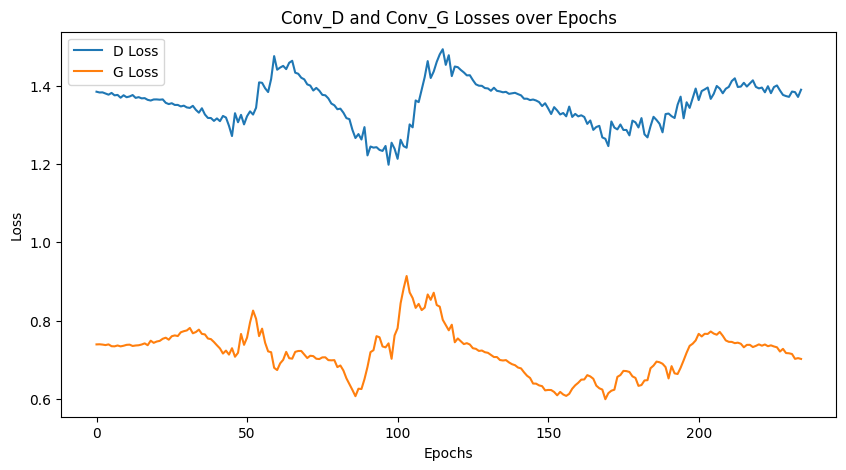

In [45]:
#-- CNN LOSS 시각화

# 로스 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(Conv_D_losses, label='D Loss')
plt.plot(Conv_G_losses, label='G Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Conv_D and Conv_G Losses over Epochs')
plt.show()

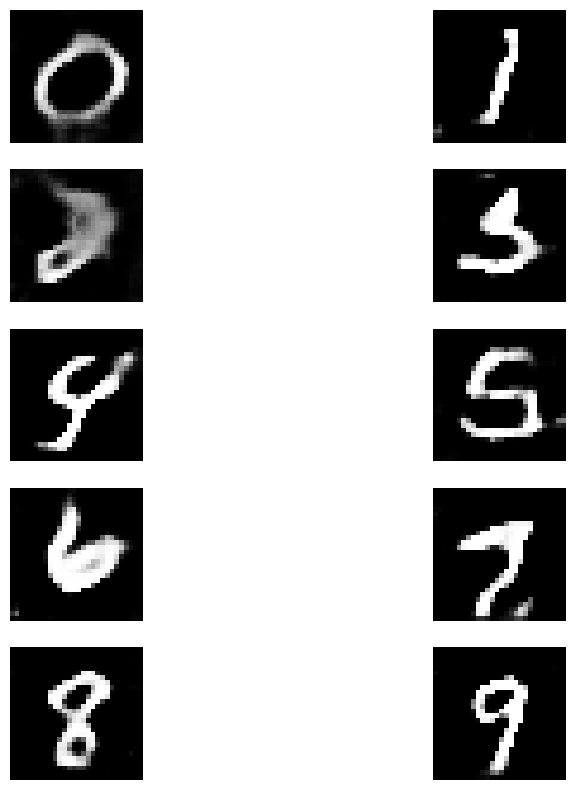

In [46]:
# CNN Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

Conv_G.eval()
noises = torch.randn(10, 100, device=device)
label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label_encoded = F.one_hot(label, num_classes=num_classes).to(device)
generated_image = Conv_G(noises,label_encoded ).cpu().detach().numpy().squeeze()


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## TODO (4)

위의 내용을 noise의 dim 값을 바꾸어 실험해 본다.

In [47]:
noise_dim = 300

#-- 고정된 값 생성
sample_noises = torch.randn((16, noise_dim), device=device)
sample_conditional = torch.randint(0,10,(16,), device=device)
sample_conditional = F.one_hot(sample_conditional, num_classes=10).to(device)


In [48]:
## TODO
class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear     = torch.nn.Linear(noise_dim + num_classes, 7*7*512, bias=False) 
        self.bn        = torch.nn.BatchNorm1d(num_features=7*7*512)

        self.convt1     = torch.nn.ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn1        = torch.nn.BatchNorm2d(256)

        self.convt2     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn2        = torch.nn.BatchNorm2d(128)
        self.convt3     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
        self.bn3        = torch.nn.BatchNorm2d(64)
        self.convt4     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
      z = self.lrelu(self.bn(self.linear(z))).reshape(-1, 512, 7, 7)
      z = self.lrelu(self.bn1(self.convt1(z)))
      z = self.lrelu(self.bn2(self.convt2(z)))
      z = self.lrelu(self.bn3(self.convt3(z)))
      z = self.tanh(self.convt4(z)).reshape(-1, 1, 28, 28)

      return z

    def forward(self, z, c):
      z = torch.cat((z, c), dim=1)
      z = self.generator(z)

      return z


## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1      = torch.nn.Conv2d(1+num_classes, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
      self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)

      self.conv3      = torch.nn.Conv2d(128, 256, (4, 4), stride=(2, 2), padding=1, bias=False)
      self.conv4      = torch.nn.Conv2d(256, 512, (4, 4), stride=(2, 2), padding=1, bias=False)

      self.flatten    = torch.nn.Flatten()
      self.linear     = torch.nn.Linear(7*7*512, 1, bias=False)

      self.lrelu      = torch.nn.LeakyReLU()
      self.sigmoid    = torch.nn.Sigmoid()
      self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
      z = self.dropout(self.lrelu(self.conv1(z)))
      z = self.dropout(self.lrelu(self.conv2(z)))
      z = self.dropout(self.lrelu(self.conv3(z)))
      z = self.flatten(self.dropout(self.lrelu(self.conv4(z))))
  
      z = self.sigmoid(self.linear(z))

      return z

    def forward(self, z):
      c = c.view(-1, 10, 1, 1)
      c = c.expand(-1, 10, -1, -1)
      z = torch.cat([z, c], dim=-3)
      z = self.discriminator(z)

      return z
Conv_G = CondGenerator().to(device)
Conv_D = Discriminator().to(device)

# CNN_Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
Conv_D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = Conv_D(fake_image_test, conditional)  

# CNN_GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# CNN_GAN 트레이닝에 쓰일 optimizer 정의
Conv_G_optimizer = torch.optim.Adam(Conv_G.parameters(), lr=learning_rate)
Conv_D_optimizer = torch.optim.Adam(Conv_D.parameters(), lr=learning_rate)

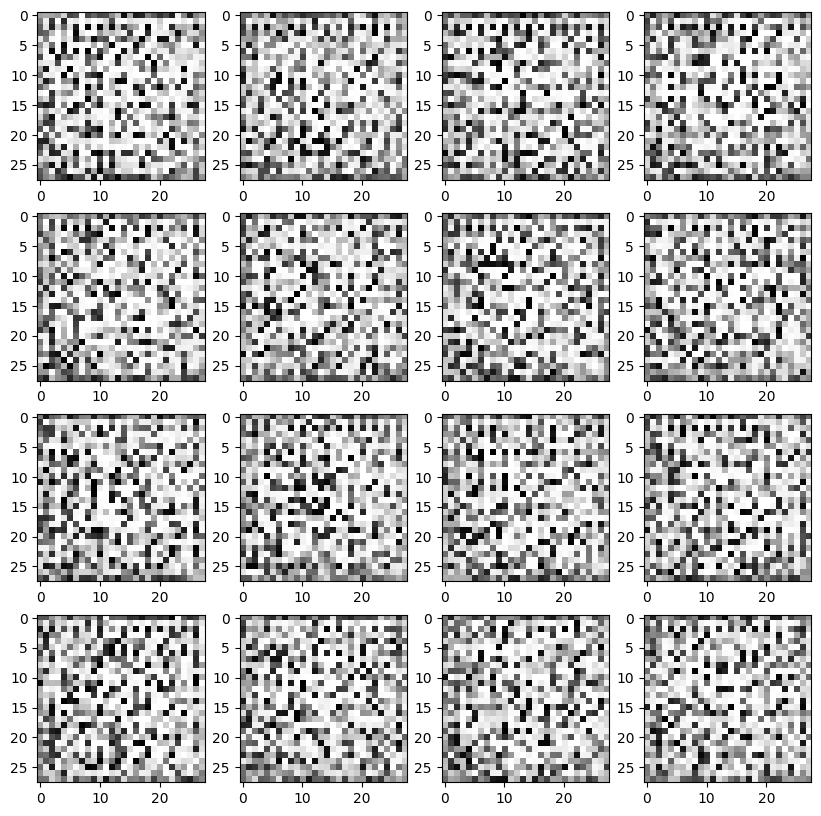

[0/50][0/235]	Loss_Conv_D: 1.3953	Loss_Conv_G: 0.7063	D(x): 0.4920	Conv_D(Conv_G(z)): 0.4963 / 0.4935
[0/50][50/235]	Loss_Conv_D: 0.2838	Loss_Conv_G: 1.7780	D(x): 0.9957	Conv_D(Conv_G(z)): 0.2424 / 0.1756
[0/50][100/235]	Loss_Conv_D: 0.0279	Loss_Conv_G: 5.4889	D(x): 0.9990	Conv_D(Conv_G(z)): 0.0260 / 0.0080
[0/50][150/235]	Loss_Conv_D: 0.0205	Loss_Conv_G: 8.3151	D(x): 0.9894	Conv_D(Conv_G(z)): 0.0087 / 0.0021
[0/50][200/235]	Loss_Conv_D: 0.0166	Loss_Conv_G: 10.1317	D(x): 0.9940	Conv_D(Conv_G(z)): 0.0081 / 0.0012
[1/50][0/235]	Loss_Conv_D: 0.0041	Loss_Conv_G: 10.3853	D(x): 0.9975	Conv_D(Conv_G(z)): 0.0016 / 0.0021
[1/50][50/235]	Loss_Conv_D: 0.0279	Loss_Conv_G: 7.5551	D(x): 0.9868	Conv_D(Conv_G(z)): 0.0111 / 0.0091
[1/50][100/235]	Loss_Conv_D: 0.1265	Loss_Conv_G: 6.4120	D(x): 0.9637	Conv_D(Conv_G(z)): 0.0497 / 0.0284
[1/50][150/235]	Loss_Conv_D: 0.0838	Loss_Conv_G: 5.0031	D(x): 0.9808	Conv_D(Conv_G(z)): 0.0487 / 0.0413
[1/50][200/235]	Loss_Conv_D: 0.0181	Loss_Conv_G: 6.7232	D(x): 0.9926

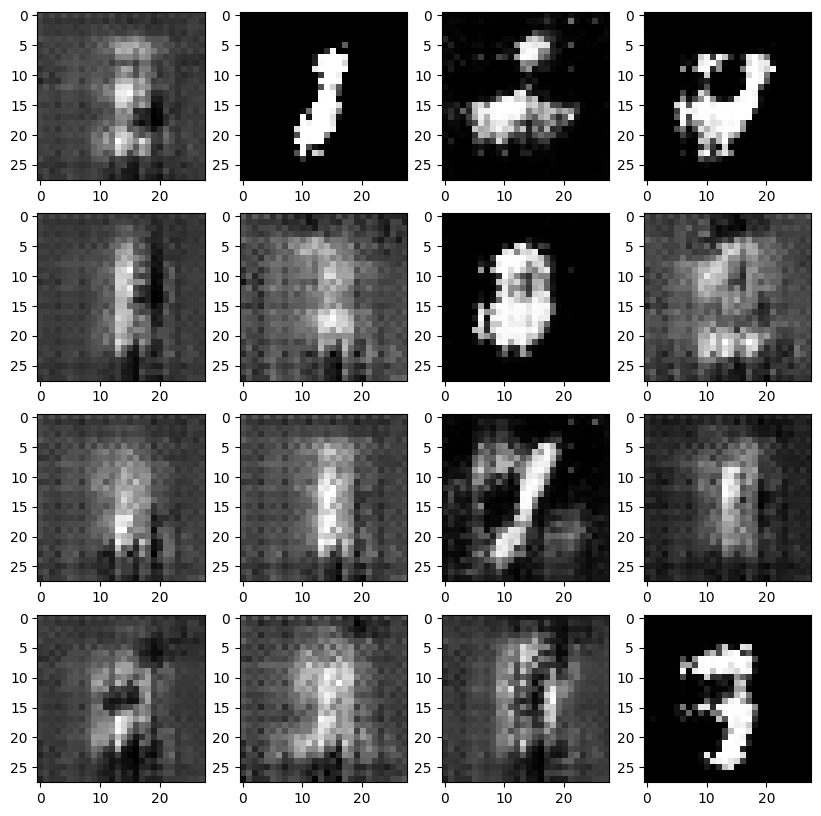

[10/50][0/235]	Loss_Conv_D: 0.3245	Loss_Conv_G: 4.4563	D(x): 0.8952	Conv_D(Conv_G(z)): 0.1197 / 0.0806
[10/50][50/235]	Loss_Conv_D: 0.5393	Loss_Conv_G: 4.0921	D(x): 0.8510	Conv_D(Conv_G(z)): 0.1165 / 0.0880
[10/50][100/235]	Loss_Conv_D: 0.3253	Loss_Conv_G: 4.8582	D(x): 0.9063	Conv_D(Conv_G(z)): 0.0896 / 0.1105
[10/50][150/235]	Loss_Conv_D: 0.4069	Loss_Conv_G: 5.0361	D(x): 0.8456	Conv_D(Conv_G(z)): 0.0651 / 0.0705
[10/50][200/235]	Loss_Conv_D: 0.4558	Loss_Conv_G: 4.5582	D(x): 0.8628	Conv_D(Conv_G(z)): 0.1101 / 0.0855
[11/50][0/235]	Loss_Conv_D: 0.4372	Loss_Conv_G: 3.1957	D(x): 0.8774	Conv_D(Conv_G(z)): 0.1895 / 0.1250
[11/50][50/235]	Loss_Conv_D: 0.5026	Loss_Conv_G: 3.0958	D(x): 0.8999	Conv_D(Conv_G(z)): 0.2028 / 0.1524
[11/50][100/235]	Loss_Conv_D: 0.4129	Loss_Conv_G: 3.9597	D(x): 0.8924	Conv_D(Conv_G(z)): 0.1318 / 0.1049
[11/50][150/235]	Loss_Conv_D: 0.3048	Loss_Conv_G: 7.0687	D(x): 0.9105	Conv_D(Conv_G(z)): 0.1055 / 0.0312
[11/50][200/235]	Loss_Conv_D: 0.4179	Loss_Conv_G: 3.0467	D(x)

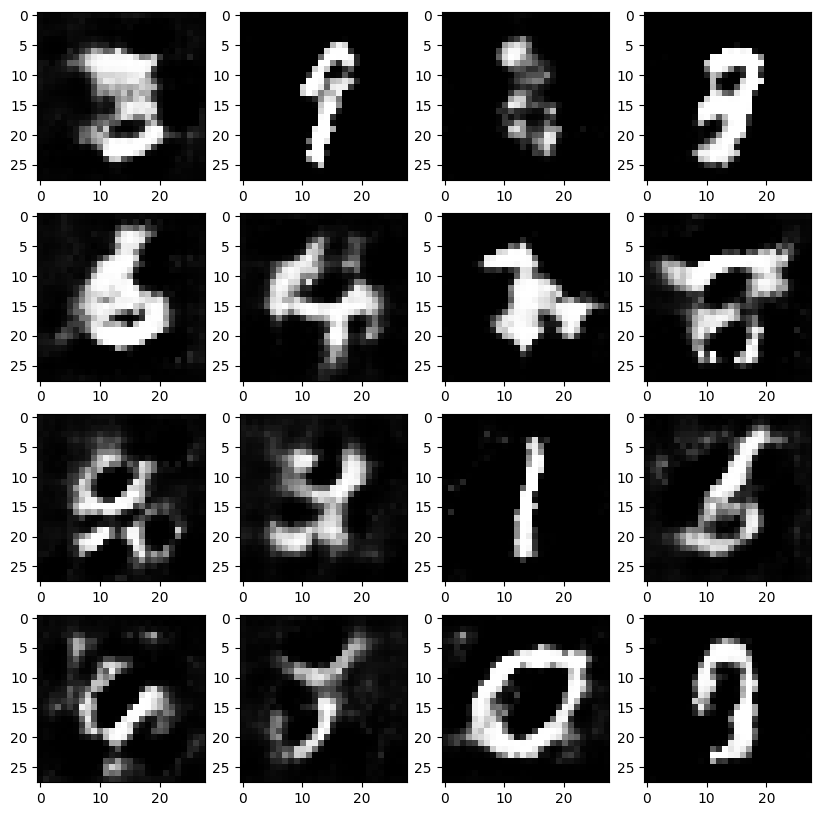

[20/50][0/235]	Loss_Conv_D: 0.9140	Loss_Conv_G: 1.7220	D(x): 0.7261	Conv_D(Conv_G(z)): 0.3271 / 0.2914
[20/50][50/235]	Loss_Conv_D: 0.9953	Loss_Conv_G: 1.4684	D(x): 0.7159	Conv_D(Conv_G(z)): 0.3530 / 0.3131
[20/50][100/235]	Loss_Conv_D: 0.9005	Loss_Conv_G: 1.9303	D(x): 0.7711	Conv_D(Conv_G(z)): 0.3182 / 0.2565
[20/50][150/235]	Loss_Conv_D: 0.7106	Loss_Conv_G: 2.2017	D(x): 0.8171	Conv_D(Conv_G(z)): 0.2656 / 0.2433
[20/50][200/235]	Loss_Conv_D: 0.9057	Loss_Conv_G: 1.5507	D(x): 0.7270	Conv_D(Conv_G(z)): 0.3258 / 0.2994
[21/50][0/235]	Loss_Conv_D: 0.8531	Loss_Conv_G: 1.5065	D(x): 0.7397	Conv_D(Conv_G(z)): 0.3186 / 0.3121
[21/50][50/235]	Loss_Conv_D: 0.8626	Loss_Conv_G: 1.5043	D(x): 0.7513	Conv_D(Conv_G(z)): 0.3325 / 0.3141
[21/50][100/235]	Loss_Conv_D: 0.8879	Loss_Conv_G: 1.7720	D(x): 0.7138	Conv_D(Conv_G(z)): 0.2825 / 0.2944
[21/50][150/235]	Loss_Conv_D: 0.9652	Loss_Conv_G: 1.4525	D(x): 0.6671	Conv_D(Conv_G(z)): 0.3181 / 0.3201
[21/50][200/235]	Loss_Conv_D: 0.9476	Loss_Conv_G: 1.3878	D(x)

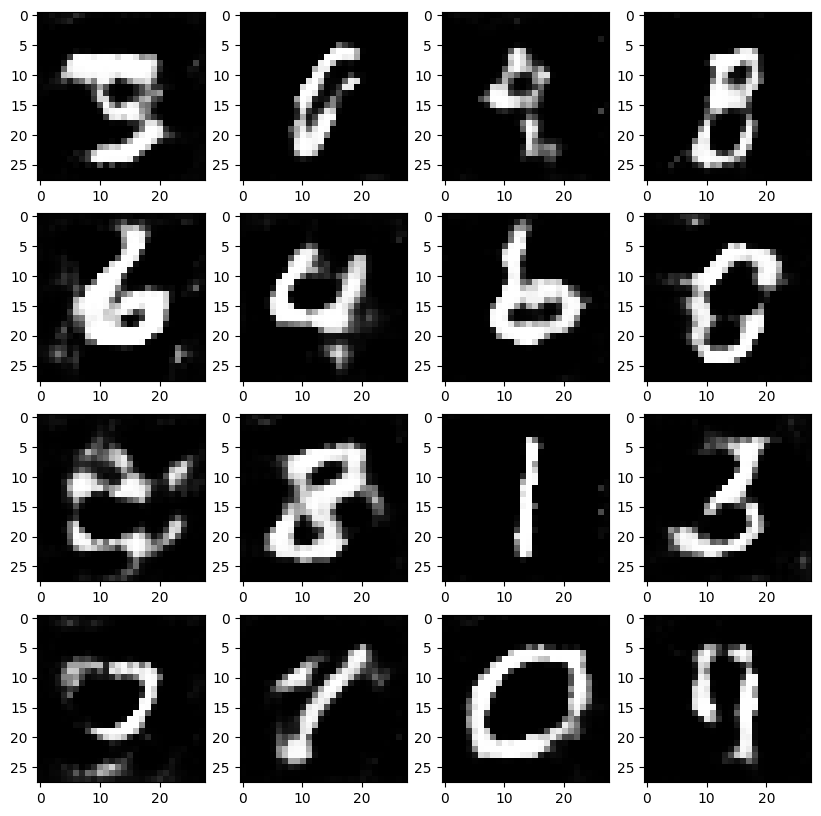

[30/50][0/235]	Loss_Conv_D: 1.1201	Loss_Conv_G: 1.4401	D(x): 0.5629	Conv_D(Conv_G(z)): 0.3450 / 0.3005
[30/50][50/235]	Loss_Conv_D: 1.2359	Loss_Conv_G: 0.9712	D(x): 0.5865	Conv_D(Conv_G(z)): 0.4351 / 0.4209
[30/50][100/235]	Loss_Conv_D: 1.1836	Loss_Conv_G: 0.8759	D(x): 0.5726	Conv_D(Conv_G(z)): 0.4267 / 0.4306
[30/50][150/235]	Loss_Conv_D: 1.1953	Loss_Conv_G: 1.1140	D(x): 0.5927	Conv_D(Conv_G(z)): 0.4101 / 0.3873
[30/50][200/235]	Loss_Conv_D: 1.1220	Loss_Conv_G: 1.2639	D(x): 0.6034	Conv_D(Conv_G(z)): 0.3597 / 0.3582
[31/50][0/235]	Loss_Conv_D: 1.2182	Loss_Conv_G: 1.2137	D(x): 0.5763	Conv_D(Conv_G(z)): 0.4021 / 0.3611
[31/50][50/235]	Loss_Conv_D: 1.0873	Loss_Conv_G: 1.1910	D(x): 0.6165	Conv_D(Conv_G(z)): 0.3881 / 0.3801
[31/50][100/235]	Loss_Conv_D: 1.2052	Loss_Conv_G: 0.9374	D(x): 0.5711	Conv_D(Conv_G(z)): 0.4206 / 0.4216
[31/50][150/235]	Loss_Conv_D: 1.1597	Loss_Conv_G: 1.0023	D(x): 0.5957	Conv_D(Conv_G(z)): 0.4245 / 0.4013
[31/50][200/235]	Loss_Conv_D: 1.3096	Loss_Conv_G: 0.9380	D(x)

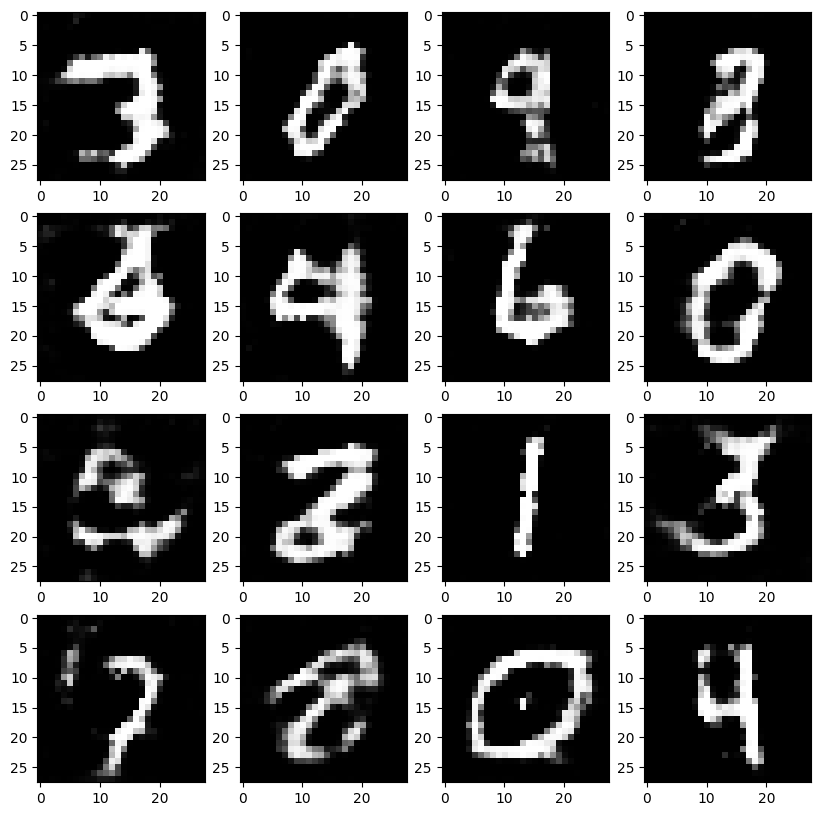

[40/50][0/235]	Loss_Conv_D: 1.0545	Loss_Conv_G: 1.2925	D(x): 0.6442	Conv_D(Conv_G(z)): 0.3917 / 0.3562
[40/50][50/235]	Loss_Conv_D: 1.2285	Loss_Conv_G: 1.1126	D(x): 0.5420	Conv_D(Conv_G(z)): 0.3902 / 0.3890
[40/50][100/235]	Loss_Conv_D: 1.2978	Loss_Conv_G: 0.8641	D(x): 0.5418	Conv_D(Conv_G(z)): 0.4543 / 0.4493
[40/50][150/235]	Loss_Conv_D: 1.2912	Loss_Conv_G: 0.8119	D(x): 0.5662	Conv_D(Conv_G(z)): 0.4760 / 0.4580
[40/50][200/235]	Loss_Conv_D: 1.2658	Loss_Conv_G: 0.8441	D(x): 0.5430	Conv_D(Conv_G(z)): 0.4457 / 0.4507
[41/50][0/235]	Loss_Conv_D: 1.2727	Loss_Conv_G: 0.8970	D(x): 0.5643	Conv_D(Conv_G(z)): 0.4541 / 0.4394
[41/50][50/235]	Loss_Conv_D: 1.2689	Loss_Conv_G: 0.9288	D(x): 0.5090	Conv_D(Conv_G(z)): 0.4122 / 0.4198
[41/50][100/235]	Loss_Conv_D: 1.2564	Loss_Conv_G: 1.0052	D(x): 0.5408	Conv_D(Conv_G(z)): 0.4254 / 0.4093
[41/50][150/235]	Loss_Conv_D: 1.3030	Loss_Conv_G: 0.8030	D(x): 0.5436	Conv_D(Conv_G(z)): 0.4701 / 0.4628
[41/50][200/235]	Loss_Conv_D: 1.2732	Loss_Conv_G: 0.8547	D(x)

In [50]:
#-- CNN Train

#-- 고정된 값 생성
sample_noises = torch.randn((16, noise_dim), device=device)
sample_conditional = torch.randint(0,10,(16,), device=device)
sample_conditional = F.one_hot(sample_conditional, num_classes=10).to(device)

Conv_G.train()
Conv_D.train()

train_hist = {}
train_hist['Conv_D_losses'] = []
train_hist['Conv_G_losses'] = []

for epoch in range(EPOCHS):
  Conv_D_losses = []
  Conv_G_losses = []

  if epoch % 10 == 0: #-- 10epoch마다 고정된 노이즈 값 시각화
    smaple_images = Conv_G(sample_noises, sample_conditional)
    plt.figure(figsize=(10,10))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.imshow(smaple_images[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
    plt.show()

  for i, (images, train_labels) in enumerate(train_loader):

    train_labels_one_hot = F.one_hot(train_labels, num_classes=10).to(device)
    #############################
    # 1) Update discriminator D #
    #############################
    Conv_D.zero_grad()

    images_real = images.to(device)
    y_pred_real = Conv_D(images_real, train_labels_one_hot).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    Conv_D_real_loss = criterion(y_pred_real, label)
    Conv_D_real_loss.backward()

    Conv_D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = Conv_G(noises, train_labels_one_hot)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = Conv_D(images_fake.detach(), train_labels_one_hot).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    Conv_D_fake_loss = criterion(y_pred_fake, label)
    Conv_D_fake_loss.backward()

    Conv_D_G_z1 = y_pred_fake.mean().item()

    Conv_D_loss = Conv_D_real_loss + Conv_D_fake_loss

    # Update D
    Conv_D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    Conv_G.zero_grad()

    y_pred_fake = Conv_D(images_fake, train_labels_one_hot).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    Conv_G_loss = criterion(y_pred_fake, label)
    Conv_G_loss.backward()

    Conv_D_G_z2 = y_pred_fake.mean().item()

    # Update G
    Conv_G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_Conv_D: %.4f\tLoss_Conv_G: %.4f\tD(x): %.4f\tConv_D(Conv_G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     Conv_D_loss.item(), Conv_G_loss.item(), Conv_D_x, Conv_D_G_z1, Conv_D_G_z2))
    
    Conv_D_losses.append(Conv_D_loss.item())
    Conv_G_losses.append(Conv_G_loss.item())
            
  train_hist['Conv_D_losses'].append(torch.mean(torch.Tensor(Conv_D_losses)))
  train_hist['Conv_G_losses'].append(torch.mean(torch.Tensor(Conv_G_losses)))

print('Conv Training Finished!')

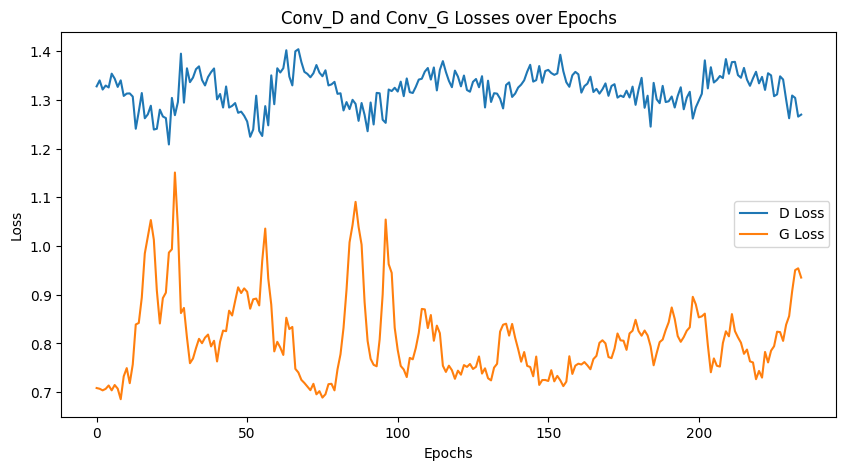

In [51]:
#-- CNN LOSS 시각화

# 로스 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(Conv_D_losses, label='D Loss')
plt.plot(Conv_G_losses, label='G Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Conv_D and Conv_G Losses over Epochs')
plt.show()

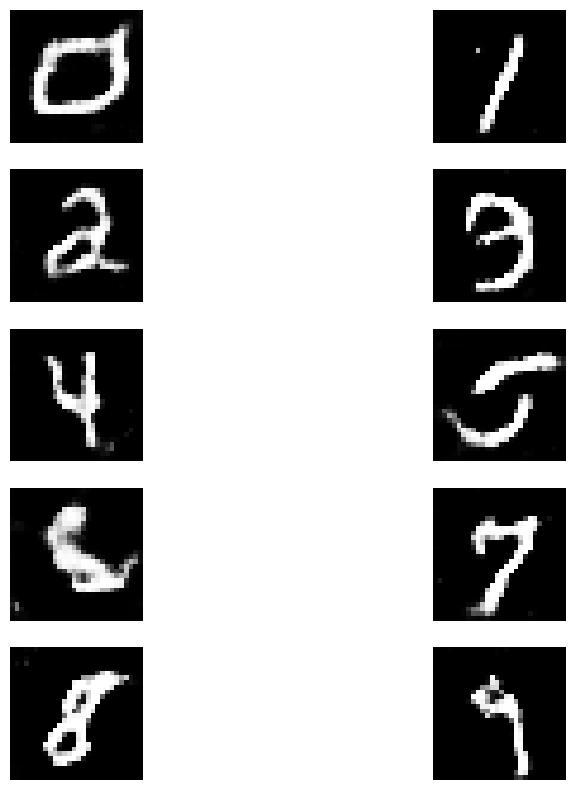

In [52]:
# CNN Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

Conv_G.eval()
noises = torch.randn(10, noise_dim, device=device)
label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label_encoded = F.one_hot(label, num_classes=num_classes).to(device)
generated_image = Conv_G(noises,label_encoded ).cpu().detach().numpy().squeeze()


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

### 최종결과

##### TODO 1

-  FC레이어로 구성 후 Conv레이어와 비교 

FC레이어로 linear하게 신경망을 구성한 결과 CNN구조로 신경망을 구성했을 때보다 생성모델의 정확도가 현저히 떨어지는걸 확인할 수 있었다. 또한 간단한 문제임에도 신경망이 복잡해짐에 따라 오버피팅 문제가 발생하여 두 모델 모두 드롭아웃을 추가하여 신경망의 복잡도를 줄였다. MNIST와 같은 간단한 손글씨 분류문제임에도 불구하고 CNN과 FC레이어에 차이를 한눈에 확인해볼 수 있었다.

##### TODO 2,3

-  고정된 noise값을 생성하여 시각화하고 로스값을 시각화
고정된 noise값을 생성하여 7이 생성되는 과정을 시각화 해보았다. 처음 랜덤 noise에서 생성된 이미지는 형체를 알아볼 수 없었지만 epoch이 증가함에 따라 Generator가 생성하는 이미지의 형태가 점점 선명해짐을 확인해볼 수 있었고 역시나 CNN구조의 모델이 더 빠르게 안정적인 데이터를 생성하는 걸 알 수 있었다. 하지만 CNN구조 같은경우는 학습시간이 FC보다 더욱 오래걸렸다.



##### TODO 4

-  noise값을 변경하고 확인

이전 noise_dim = 100을 300으로 변경한 후 관찰한 결과 엄청나게 큰 유의미한 결과를 확인할 수는 없었다고 생각한다. 다만 100보다는 생성된 이미지가 약간 더 선명하다는걸 확인할 수 있었다. 

##### 최종결과 

확실하게 이전에 실습했던 VAE모델보다는 신경망 자체가 조금 더 어려운 느낌이 들었다. 뿐만 아니라 이전에 VAE모델같은 경우에는 생성모델이 input으로 들어온 이미지에 대해서만 생성을 했지만 GAN모델 같은 경우에는 자신이 랜덤하게 생성한 noise로 이미지를 생성하기 때문에 학습이미지로 들어온 이미지가 아닌 자신의 랜덤한 노이즈에서 생성한 이미지를 만드는것을 확인할 수 있었다.


